In [1]:
from datasets import wine_white_dataset
import pandas as pd
wine_white = wine_white_dataset()
wine_white.dropna(how='all', inplace=True)

Under the assumption that we do not have many features and many of these few features have low impact on quality, it is assumed to be more effective when we sort out good features rather than reducing many features into a smaller amount.

In some cases, applying both methods of data reduction may make sense. It would make more sense to apply both methods when we have a large amount of base features and still a large amount of features after selecting good ones. But if we only have just a few good features, we should not reduce them further.

# Feature selection

## VIF

When a model is trained with colinear features, the coefficients (weights) tend to depend on each other which reduces explanability of the model. Find features that have high colinearity. 

Variance Inflation Factor, measures how much the variance of an estimated regression coefficient is increased because of collinearity

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def get_vifs_white_wine(x):
    vif_factors = pd.Series([variance_inflation_factor(x.values, i) for i in range(x.shape[1])], index=x.columns)
    vif_factors = round(vif_factors, 2)
    return vif_factors
display(get_vifs_white_wine(wine_white.dropna().drop('quality', axis=1).drop('ID', axis=1)))

fixed acidity                 2.70
volatile acidity              1.14
citric acid                   1.17
residual sugar               12.64
chlorides                     1.24
flavanoids              3062203.80
free sulfur dioxide           1.79
total sulfur dioxide          2.24
density                      28.22
pH                            2.20
magnesium                     1.00
sulphates                     1.14
alcohol                      10.17
lightness                     3.77
dtype: float64

- => alcohol and lightness seem to have high colinearity
- => residual sugar and density seem to have high colinearity

In [12]:
display(wine_white['alcohol'].corr(wine_white['lightness']))
display(get_vifs_white_wine(wine_white.dropna().drop('quality', axis=1).drop('ID', axis=1).drop('lightness',axis=1)))

-0.8563701904472735

fixed acidity                 2.70
volatile acidity              1.14
citric acid                   1.17
residual sugar               12.64
chlorides                     1.24
flavanoids              3062199.21
free sulfur dioxide           1.79
total sulfur dioxide          2.24
density                      28.21
pH                            2.20
magnesium                     1.00
sulphates                     1.14
alcohol                       7.69
dtype: float64

In [4]:
wine_white['residual sugar'].corr(wine_white['density'])

0.8389412171940377

alcohol and lightness have high negative correlation

In [14]:
display(get_vifs_white_wine(wine_white.dropna().drop('quality', axis=1).drop('lightness',axis=1).drop('residual sugar', axis=1).drop('ID', axis=1)))

fixed acidity                1.47
volatile acidity             1.14
citric acid                  1.16
chlorides                    1.19
flavanoids              358954.40
free sulfur dioxide          1.73
total sulfur dioxide         2.20
density                      3.21
pH                           1.31
magnesium                    1.00
sulphates                    1.06
alcohol                      3.01
dtype: float64

when removing lightness and residual sugar as a feature, the colinearities mostly disappears

## Information Gain

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import numpy as np

wine_white_nan = wine_white.dropna()
x = wine_white_nan.drop('ID', axis=1).drop('quality', axis=1)
y = wine_white_nan['quality']

def get_kbest_sorted(selector,x,y,iterations):
    flt = SelectKBest(selector).fit(x,y)
    scores = flt.scores_
    best_features = pd.DataFrame(scores,index=x.columns, columns=['score'])
    for i in range(1,iterations):
        np.random.seed(i)
        flt = SelectKBest(selector).fit(x,y)
        scores = flt.scores_
        df = pd.DataFrame(scores,index=x.columns, columns=['score'])
        best_features = df + best_features
    best_features = best_features / i
    best_features = best_features.sort_values(by=['score'], ascending=False)
    return best_features

#filtering using Mutual Information = Information Gain
kbest_mutual_info_regression = get_kbest_sorted(mutual_info_regression, x, y, 50)

display(kbest_mutual_info_regression)

,score
density,0.183492
alcohol,0.159911
residual sugar,0.092866
lightness,0.092715
total sulfur dioxide,0.092563
chlorides,0.065917
free sulfur dioxide,0.056186
citric acid,0.051313
volatile acidity,0.048197
pH,0.033859


The mutual_info_regression selector is dependent on random state, which is different every execution. Because of this condition we calculate a mean over 25 iterations to have a more secure output

we could delete following features:
- citric acid	0.054419
- volatile acidity	0.049337
- pH	0.035531
- sulphates	0.029169
- fixed acidity	0.028996
- magnesium	0.003859
- flavanoids	0.001020

We could also merge them into one feature

## Correlation

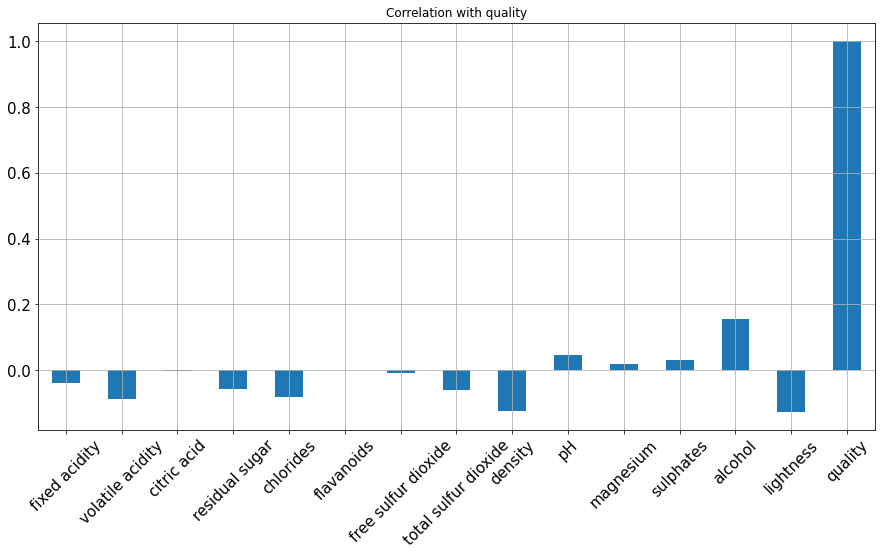

In [7]:
wine_white.drop('ID', axis=1).corrwith(wine_white['quality']).plot.bar(
        figsize = (15, 7.5), title = "Correlation with quality", fontsize = 15,
        rot = 45, grid = True)

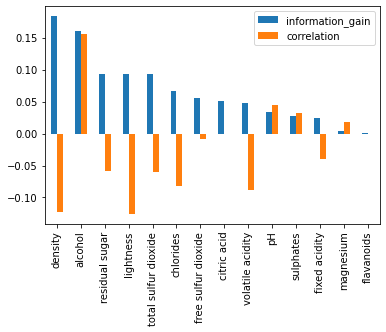

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Build new DataFrame for information gain and correlation side by side
corr = wine_white.drop('ID', axis=1).corrwith(wine_white['quality'])
features = kbest_mutual_info_regression.index
values = []
for feature in features:
    # access correct values by index
    values.append([kbest_mutual_info_regression.loc[feature,'score'], corr[feature]])
df = pd.DataFrame(values, columns=['information_gain', 'correlation'], index=features)
df.plot.bar()

plt.show()

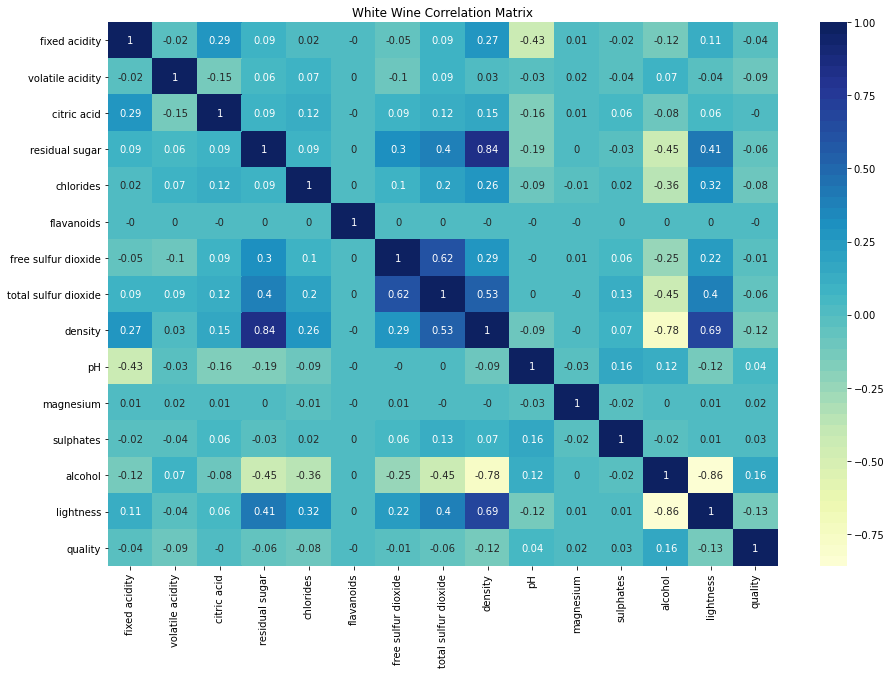

In [9]:
import seaborn as sns
correlations = round(wine_white.drop('ID', axis=1).corr(), 2)
plt.figure(figsize = (15, 10))
ax = sns.heatmap(correlations, annot=True, cmap = sns.color_palette("YlGnBu", 50))
ax.axes.set_title("White Wine Correlation Matrix")
plt.show()

In [ ]:
Flavanoids have a constant value across all data. This leads to a variance of zero and hence an undefined correlation with other features, since division by zero is not possible.

Highest correlating features:
- density / residual sugar 0.84
- lightness / density 0.69
- total sulfur dioxide / free sulfur dioxide 0.62
- total sulfur dioxide / density 0.53
- lightness / residual sugar 0.41

most negatively correlating features:
- alcohol / lightness -0.86
- alcohol / density -0.78
- total sulfur dioxide / alcohol -0.45
- residual sugar / alcohol -0.45


## Summary
We work with a minimum information gain of 0.05
- use alcohol and density as the major describing features.
- lightness and residual sugar have high colinearity with alcohol and density + high correlation. Better to remove them
- total sulfur dioxide has high correlation with alcohol, density and free sulfur dioxide. We can keep it or remove it, based on the impact on the model
- use chlorides as a feature
- use free sulfur dioxide as a feature
- use citric acid as a feature
- use volatile acidity as a feature
- remove all other features

# Feature reduction

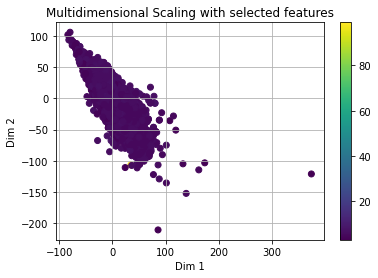

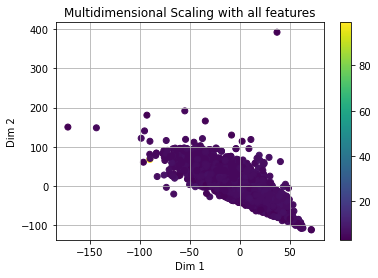

In [17]:
#Multidimensional scaling
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
selected_features = ['alcohol', 'density', 'total sulfur dioxide', 'chlorides', 'free sulfur dioxide', 'citric acid', 'volatile acidity']
def visualize_MDS(data_transformed, label_transformed, title):
    #Create a matplot scatter plot visualizing the transformed data, indicating the target through color
    plt.scatter(data_transformed[:,0],data_transformed[:,1],c=label_transformed)
    plt.title(title)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.grid()
    plt.colorbar()
    plt.show()

x_selected = wine_white.dropna()[selected_features]
x_all = wine_white.dropna().drop('ID', axis=1).drop('quality',axis=1)
y = wine_white.dropna()['quality']

embedding_selected = MDS(n_components=2)
embedding_all = MDS(n_components=2)
data_trans_selected = embedding_all.fit_transform(x_selected)
data_trans_all = embedding_all.fit_transform(x_all)
label_trans= y

visualize_MDS(data_trans_selected, label_trans, "Multidimensional Scaling with selected features")
visualize_MDS(data_trans_all, label_trans, "Multidimensional Scaling with all features")

- Our feature selection seems to have an impact on the MDS, because there is a more strict border between good quality red wine and bad quality red wine
- If a linear regression function is drawn inside the dataset, it is indicated that there is a linear dependency of quality.
- Higher valued dimensions seem to result in higher quality.